# Homework 10 - JPEG (Incomplete)

# Introduction
JPEG is a commonly used method of lossy compression for digital images, particularly for those images produced by digital photography. The degree of compression can be adjusted, allowing a selectable tradeoff between storage size and image quality.

# Method
We will be following the way JPEG was made using DCT and dividing it by a quantization matrix to keep the important information.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.linalg as l
from IPython.display import display, Math, Latex
import math
from PIL import Image, ImageFilter
import os, os.path
import glob
from copy import deepcopy, copy
from math import trunc, log, floor

In [2]:
# Image resizing
def average_channel(channel):
    ret = []
    #print(channel.shape)
    for i in range(0,channel.shape[0],2):
        img_row = []
        for j in range(0,channel.shape[1],2):
            #print(channel[i][j])
            #print(channel[i+1][j])
            #print(channel[i][j+1])
            #print(channel[i+1][j+1])
            avg = int(channel[i][j]) + int(channel[i+1][j]) + int(channel[i][j+1]) + int(channel[i+1][j+1])
            #print(avg)
            avg = avg/4
            img_row.append(np.uint8(avg))
        #print(img_row)
        ret.append(img_row)
    
    return np.array(ret)

def reduce_image(image):
    if(len(image.shape) < 3):
        image = image.reshape(image.shape[0],image.shape[1],1)
    if(image.dtype == 'float32'):
        image = image*255
    
    width = image.shape[0]
    height = image.shape[1]
    channels = image.shape[2]
    #print(image.shape[0])
    if((width%2) == 1):
        image = image[:-1,:,:]
        #print(image.shape[0])
        width-=1
        
    if((height%2) == 1):
        image = image[:,:-1,:]
        #print(image.shape[0])
        height-=1
        
    #plt.imshow(image,cmap='gray')
    #plt.show()
    if(channels > 1):
        red = np.reshape(image[...,0],(width,height))
        green = np.reshape(image[...,1],(width,height))
        blue = np.reshape(image[...,2],(width,height))
    elif(channels==1):
        red = np.reshape(image[...,0],(width,height))
        green = np.reshape(image[...,0],(width,height))
        blue = np.reshape(image[...,0],(width,height))
    else:
        raise Exception("Invalid image channels")
        
    average_red = average_channel(red)
    average_green = average_channel(green)
    average_blue = average_channel(blue)
    #ret = np.append(np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),axis=-1)
    #ret = np.append(ret,np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),axis=-1)
    ret = np.append(np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),np.reshape(average_green,(average_green.shape[0],average_green.shape[1],1)),axis=-1)
    ret = np.append(ret,np.reshape(average_blue,(average_blue.shape[0],average_blue.shape[1],1)),axis=-1)
    return ret
    
    

In [3]:
def display_DFT(computed_DFT):
    return np.sqrt(np.square(computed_DFT[0])  +  np.square(computed_DFT[1]))
def scale_display(disp):
    maximum = np.max(disp)
    return ((255/np.log10(255))*np.log10(1+(255/maximum)*disp)).astype('int32')

In [4]:
def delt(inp):
    if(inp == 0):
        return 1/np.sqrt(2)
    return 1

def DCT_channel(image):
    ret = np.zeros((image.shape[0],image.shape[1],1))
    for v in range(image.shape[1]):
        #print('v = \n',v)
        for u in range(image.shape[0]):
            
            
            #print('u = \n',u)
            real = 0

            for y in range(image.shape[1]):
                for x in range(image.shape[0]):
                    factor = (delt(y)/(np.sqrt(2/image.shape[1])))*(delt(x)/(np.sqrt(2/image.shape[0])))
                    f = image[x][y]
                    x_factor = math.cos(((2*x)+1)*u*math.pi/(2*image.shape[0]))
                    y_factor = math.cos(((2*y)+1)*v*math.pi/(2*image.shape[1]))
                    real  = real + (f*x_factor*y_factor*factor)
            ret[u][v][0] = real
    return (ret)

def DFT_centered(image):
    ret = np.zeros((image.shape[0],image.shape[1],2))
    for v in range(image.shape[1]):
        #print('v = \n',v)
        for u in range(image.shape[0]):
            #print('u = \n',u)
            real = 0
            imag = 0
            for y in range(image.shape[1]):
                for x in range(image.shape[0]):
                    f = image[x][y]*((-1)**(x+y))
                    inner = ((u*x)/image.shape[0]) + ((v*y)/image.shape[1])
                    inner = inner *  (-2*math.pi )
                    real_part = math.cos(inner)
                    imaginary_part = math.sin(inner)
                    real = real + f*real_part
                    imag = imag + f*imaginary_part
            ret[u][v][0] = real
            ret[u][v][1] = imag
    return (ret/image.shape[1])/image.shape[0]

In [5]:
def DCT(image,centered = False):
    if(len(image.shape) < 3):
        image = image.reshape(image.shape[0],image.shape[1],1)
    if(image.dtype == 'float32'):
        image = image*255
    
    width = image.shape[0]
    height = image.shape[1]
    channels = image.shape[2]

    if(channels > 1):
        red = np.reshape(image[...,0]/255,(width,height))
        green = np.reshape(image[...,1]/255,(width,height))
        blue = np.reshape(image[...,2]/255,(width,height))
    elif(channels==1):
        red = np.reshape(image[...,0],(width,height))
        green = np.reshape(image[...,0],(width,height))
        blue = np.reshape(image[...,0],(width,height))
    else:
        raise Exception("Invalid image channels")
    
    if(not centered):
        Transformed_red = DCT_channel(red)
        Transformed_green = DCT_channel(green)
        Transformed_blue = DCT_channel(blue)
        #print(Transformed_red.shape)
    else:
        Transformed_red = DCT_channel(red)
        Transformed_green = DCT_channel(green)
        Transformed_blue = DCT_channel(blue)
        #print(Transformed_red.shape)  
    
    Real_red = Transformed_red[...,0]
    Real_green = Transformed_green[...,0]
    Real_blue = Transformed_blue[...,0]
    
    #ret = np.append(np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),axis=-1)
    #ret = np.append(ret,np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),axis=-1)
    ret_real = np.append(np.reshape(Real_red,(Real_red.shape[0],Real_red.shape[1],1)),np.reshape(Real_green,(Real_green.shape[0],Real_green.shape[1],1)),axis=-1)
    ret_real = np.append(ret_real,np.reshape(Real_blue,(Real_blue.shape[0],Real_blue.shape[1],1)),axis=-1)
    
    #ret_imag = np.append(np.reshape(Imag_red,(Imag_red.shape[0],Imag_red.shape[1],1)),np.reshape(Imag_green,(Imag_green.shape[0],Imag_green.shape[1],1)),axis=-1)
    #ret_imag = np.append(ret_imag,np.reshape(Imag_blue,(Imag_blue.shape[0],Imag_blue.shape[1],1)),axis=-1)
  
    return ret_real

In [6]:
ima = []
for filename in glob.glob('imagesHW2/32x32/*.jpg'): #assuming gif
    img = plt.imread(filename)
    ima.append(img)

In [7]:
tansformed_img = DCT(ima[0])

C:\Users\Thony\Anaconda3\envs\DEEP\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


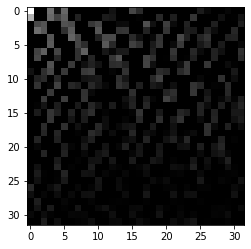

In [8]:
#display = display_DFT(tansformed_img)
display = scale_display(tansformed_img)

plt.imshow(display,cmap='gray')

In [9]:
def quantize_mat(img):
    NN = img.shape[0]
    num = 16
    
    quant = np.arange(num, num+NN) * np.arange(num, num+NN).reshape((-1, 1))
    
    return quant

In [10]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [11]:
tansformed_img = rgb2gray(tansformed_img)

In [12]:
quant = quantize_mat(ima[0])

In [13]:
quant_img = tansformed_img / quant

In [14]:
quant_img = np.floor(quant_img)

In [15]:
quant_img = quant_img.astype(int)

In [16]:
#np.set_printoptions(threshold=1000) \\ default
np.set_printoptions(threshold=10000)

In [17]:
def split(array, nrows, ncols):
    """Split a matrix into sub-matrices."""
    mat = []
    r, h = array.shape
    mat.append((array.reshape(h//nrows, nrows, -1, ncols)
                 .swapaxes(1, 2)
                 .reshape(-1, nrows, ncols)))
    return mat

In [18]:
mat = split(quant_img, 8,8)

In [19]:
mat[0][0]


array([[4748, -150, -314,  163,    7,  117,  -64,  -24],
       [ 821,  -77, -227,  131,   44,   86,  -27,   13],
       [-131,   59,   77, -109,  -25,   61,   49,  -39],
       [ -54,  144,   79,  -69,  -87,   21,   71,  -10],
       [ -58, -105,  -12,   67,  -35,  -71,   85,   37],
       [ -26,  -40,    0,   74,  -39,   -7,  -11,   33],
       [-142,   41,   83,  -78,   37,  -13,  -59,   17],
       [-132,   46,    0,  -11,   13,  -28,   -9,   17]])

In [20]:
mat2 = []
for i in range(len(mat[0])):
    mat2.append(mat[0][i])

In [21]:
mat = np.asarray(mat2)

In [22]:
def getNumString(mat):
    rows = mat.shape[0]
    col = mat.shape[1]
    a = [[] for i in range(rows+col-1)]
    for i in range(rows): 
        for j in range(col): 
            sum=i+j 
            if(sum%2 ==0): 
                a[sum].insert(0,mat[i][j]) 
            else: 
                a[sum].append(mat[i][j]) 
    numStr = []
    for i in a: 
        for j in i: 
            numStr.append(j)
    
    return numStr

In [23]:
class DC:
    def __init__(self, cat, base, l):
        self.cat = cat
        self.base = base
        self.l = l
    
    def printDC(self):
        print("cat:"+ self.cat + ' base:' + self.base + ' length:' + self.l )

In [24]:
class AC:
    def __init__(self, run,cat, base, l):
        self.run = run
        self.cat = cat
        self.base = base
        self.l = l
    def printAC(self):
        print( "run:" + self.run  + " cat:"+ self.cat + ' base:' + self.base + ' length:' + self.l )
    

In [25]:
DC_list = []

In [26]:
with open("imagesHW10/DC_code.txt", "r") as filestream:
        for line in filestream:
            currentline = line.split(",")
            DC_list.append(DC(currentline[0],currentline[1],currentline[2]))
            #print(currentline[0])
            #print(currentline[1])
            #print(currentline[2])
            

In [27]:
AC_list = []

In [28]:
with open("imagesHW10/AC_code.txt", "r") as filestream:
        for line in filestream:
            currentline = line.split(",")
            AC_list.append(AC(currentline[0][0],currentline[0][2],currentline[1],currentline[2]))
            #print(currentline[0][0])
            #print(currentline[0][2])
            #print(currentline[1])
            #print(currentline[2])

In [29]:
for DC in DC_list:
    DC.printDC()

cat:0 base:010 length:3

cat:1 base:011 length:4

cat:2 base:100 length:5

cat:3 base:00 length:5

cat:4 base:101 length:7

cat:5 base:110 length:8

cat:6 base:1110 length:10

cat:7 base:11110 length:12

cat:8 base:111110 length:14

cat:9 base:1111110 length:16

cat:A base:11111110 length:18

cat:B base:111111110 length:20

cat:C base:1111111110 length:22

cat:D base:11111111110 length:24

cat:E base:111111111110 length:26

cat:F base:1111111111110 length:28


In [30]:
for AC in AC_list:
    AC.printAC()

run:0 cat:0 base:1010 length:4

run:0 cat:1 base:00 length:3

run:0 cat:2 base:01 length:4

run:0 cat:3 base:100 length:6

run:0 cat:4 base:1011 length:8

run:0 cat:5 base:11010 length:10

run:0 cat:6 base:111000 length:12

run:0 cat:7 base:1111000 length:14

run:0 cat:8 base:1111110110 length:18

run:0 cat:9 base:11111111110000010 length:25

run:0 cat:A base:11111111110000011 length:26

run:1 cat:1 base:1100 length:5

run:1 cat:2 base:111001 length:8

run:1 cat:3 base:1111001 length:10

run:1 cat:4 base:111110110 length:13

run:1 cat:5 base:11111110110 length:16

run:1 cat:6 base:1111111110000100 length:22

run:1 cat:7 base:1111111110000101 length:23

run:1 cat:8 base:1111111110000110 length:24

run:1 cat:9 base:1111111110000111 length:25

run:1 cat:A base:1111111110001000 length:26

run:2 cat:1 base:11011 length:6

run:2 cat:2 base:11111000 length:10

run:2 cat:3 base:1111110111 length:13

run:2 cat:4 base:1111111110001001 length:20

run:2 cat:5 base:1111111110001010 length:21

run:2

In [31]:
def DecToBin(x,n):
    return format(x,'0'+ str(n) +'b')

In [32]:
def findCat(num):
    cat = 0
    
    if abs(num) > 0:
        cat = floor(log(abs(num),2)) + 1
    return cat

In [33]:
def DC_Code(num):
    cat = findCat(num)
    base = str(DC_list[cat].base)
    rem_l = int(DC_list[cat].l) - len(base)
    #print(rem_l)
    if(num>0):
        last_bins = DecToBin(num,rem_l)
    else:
        last_bins = DecToBin(num,rem_l)
        last_bins = list(last_bins)
        for i in range(len(last_bins)):
            if last_bins[i] == '0':
                last_bins[i] = '1'
            else:
                last_bins[i] = '0'
        last_bins = ''.join(last_bins[1:])
    
    
    DC_String = base + last_bins
    return DC_String

In [34]:
def AC_Code(num,zero_runs):
    cat = findCat(num)
    if 10 == cat:
        zero_runs = zero_runs + 1
        cat = str(zero_runs) + '0'
        cat = int(cat) 
        cat = cat 
    else:
        cat = str(zero_runs) + str(cat) 
        cat = int(cat)
        cat = cat 
    base = str(AC_list[cat].base)
    rem_l = int(AC_list[cat].l) - len(base)
    if(num>0):
        last_bins = DecToBin(num,rem_l)
    else:
        last_bins = DecToBin(num,rem_l)
        last_bins = list(last_bins)
        for i in range(len(last_bins)):
            if last_bins[i] == '0':
                last_bins[i] = '1'
            else:
                last_bins[i] = '0'
        last_bins = ''.join(last_bins[1:])
    
            
    AC_String = base + last_bins
    
    #print(AC_String)
    return AC_String

In [35]:
def jpeg(matrix,prev=0):
    string = ''
    zero_runs = 0
    
    #print(matrix[0])
    string = string + DC_Code(matrix[0]-prev)
    for i in range(1,len(matrix)):
        if matrix[i] == 0:
            zero_runs = zero_runs + 1
        else:
            string = string + AC_Code(matrix[i],zero_runs)
            zero_runs = 0
            #print(string)
    string = string + AC_Code(0,0)
    #print(string)
    prev = matrix[0]-prev
   # print(string)
    return string, prev


In [36]:
def full_jpeg(matrix):
    prev = 0
    string = ''
    for i in range(len(matrix)):
        c = getNumString(matrix[i])
        #print(prev)
        a , prev = jpeg(c, prev)
        string = string + a
        #print(string)
    
    
    return string

In [37]:
t = np.zeros((8,8), dtype=int)
t[0][0] = -35
t[0][2] = -1
t[0][4] = 1
t[1][1] = -2
t[2][1] = 4
print(t)
ti = getNumString(t)

[[-35   0  -1   0   1   0   0   0]
 [  0  -2   0   0   0   0   0   0]
 [  0   4   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]


In [38]:
ti

[-35,
 0,
 0,
 0,
 -2,
 -1,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [39]:
tic = jpeg(ti, -8)

In [40]:
tic[0]

'11000100111110111010001111110111100111101011010'

In [41]:
praise = full_jpeg(mat)

# Result
Here we have the image compressed to jpeg format and it holds about 6000 bits

In [42]:
praise

'111111111101001010001100111111011001101001111111111100000111100110101111111011001111100111100001100101111111111000001001100010111111101101010001111111101100001110011100011101111100000100111100000010111111101101001000011110001001101111111011010000011100111111100011101011110001011001111000001001011110001001111111100000101101101000101111111011001110001111000010111101100111111000011101011010001101111000101011011110000111111110100011111010001001110001111011111000010100011110001000011111111111000010010100111111101100111101111100010111011110001010011111100010010101110000111001101010101111000110001101111011110000110001111000100011111110000111000111000011000111100001100011111101100100111000100101100000111100010101011011010111100010010110110100101100101011110111010000111110000001001110001000011101010001101101101101010001101011111111110011010101111111100001110101001110000101011111111110000101010110001001101001110110101100011110000100111111000011000101101001110001001001011100010010111100001110010

In [43]:
# f = open("imagesHW10/jpegBin.txt", "w")
# f.write(praise)
# f.close()

In [44]:
f = open("imagesHW10/jpegBin.txt", 'r')
decode = f.read()
f.close()

In [45]:
len(decode)

6009

In [46]:
DC_list[0].l

'3\n'

In [47]:
decode

'111111111101001010001100111111011001101001111111111100000111100110101111111011001111100111100001100101111111111000001001100010111111101101010001111111101100001110011100011101111100000100111100000010111111101101001000011110001001101111111011010000011100111111100011101011110001011001111000001001011110001001111111100000101101101000101111111011001110001111000010111101100111111000011101011010001101111000101011011110000111111110100011111010001001110001111011111000010100011110001000011111111111000010010100111111101100111101111100010111011110001010011111100010010101110000111001101010101111000110001101111011110000110001111000100011111110000111000111000011000111100001100011111101100100111000100101100000111100010101011011010111100010010110110100101100101011110111010000111110000001001110001000011101010001101101101101010001101011111111110011010101111111100001110101001110000101011111111110000101010110001001101001110110101100011110000100111111000011000101101001110001001001011100010010111100001110010

# Conclusion 
JPEG was made to be a really great image compression although it does loses a bit of data when compressed it is good enough for everyday users that do not see much of the differemnce.